In [0]:
from google.colab import files
uploaded = files.upload()

Saving MNIST_clf_cifar10.tar to MNIST_clf_cifar10.tar
Saving generator_avgpool.tar to generator_avgpool.tar
Saving f_model.tar to f_model.tar
Saving final_f.tar to final_f.tar
Saving f_final_2_avg_pool.tar to f_final_2_avg_pool.tar
Saving discriminator_avgpool.tar to discriminator_avgpool.tar


In [0]:
import copy
#from base_test import BaseT|est
#import digits_model
import numpy as np
import matplotlib.pyplot as plt
#import data

import torch
import torchvision
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import os
import pandas as pd
#from torchsummary import summary
#from data import NormalizeRangeTanh, UnNormalizeRangeTanh - What the hell is this?

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.type(torch.cuda.FloatTensor)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [0]:
class generator(nn.Module):

    def __init__(self): # What to do with GPU?
        super(generator,self).__init__()
        #self.channels=channels
        #self.gpu= True
        self.use_gpu = True
        self.network=nn.Sequential(
                     nn.ConvTranspose2d(128 ,512,kernel_size=(4,4), stride=1, padding=0),
                     nn.BatchNorm2d(512),
                     nn.ReLU(inplace=True),
                     nn.ConvTranspose2d(512,256,kernel_size=(4,4), stride=2, padding=1),
                     nn.BatchNorm2d(256),
                     nn.ReLU(inplace=True),
                     nn.ConvTranspose2d(256,128,kernel_size=(4,4), stride=2, padding=1),
                     nn.BatchNorm2d(128),
                     nn.ReLU(inplace=True),
                     nn.ConvTranspose2d(128,1,kernel_size=(4,4), stride=2, padding=1),
                     nn.Tanh()
        )
        if self.use_gpu:        
                self.type(torch.cuda.FloatTensor)
    def forward(self,input):
        return self.network(input)

In [0]:
'''GEN = generator()
#summary(GEN, (128, 1, 1))'''

'GEN = generator()\n#summary(GEN, (128, 1, 1))'

In [0]:
class discriminator(nn.Module):
  
    def __init__(self, leaky_coef=0.2):
        super(discriminator, self).__init__()
        #self.channels=channels
        self.use_gpu = True

        self.leaky_coef=leaky_coef
        self.network=nn.Sequential(
                     nn.Conv2d(1,128,kernel_size=(3,3), stride=2, padding=1),
                     nn.BatchNorm2d(128),
                     nn.LeakyReLU(self.leaky_coef,inplace=True),
                     nn.Conv2d(128,256,kernel_size=(3,3), stride=2, padding=1),
                     nn.BatchNorm2d(256),
                     nn.LeakyReLU(self.leaky_coef,inplace=True),
                     nn.Conv2d(256,512,kernel_size=(3,3), stride=2, padding=1),
                     nn.BatchNorm2d(512),
                     nn.LeakyReLU(self.leaky_coef,inplace=True),
                     nn.Conv2d(512,3, kernel_size=(4,4), stride=2)
        )
        if self.use_gpu:        
            self.type(torch.cuda.FloatTensor)

            

    def forward(self,input):
        return self.network(input)

In [0]:
'''DIS = discriminator()
#summary(DIS, (1,32,32))'''

'DIS = discriminator()\n#summary(DIS, (1,32,32))'

In [0]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class feature_encoder(nn.Module):
    def __init__(self, channels,gpu=True):
        super(feature_encoder, self).__init__()
        self.gpu = gpu
        self.channels = channels
        self.classify = nn.Sequential(
                       nn.Conv2d(self.channels, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(2),               
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(2),
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(2),
                    nn.Conv2d(256, 128, kernel_size=4, padding=0))
#                     nn.ReLU(inplace=True),
#                     nn.MaxPool2d(4),
#                     Reshape(-1,128),
#                     nn.Linear(128, 10), 
#                     nn.Softmax(),)
        if self.gpu:
            self.type(torch.cuda.FloatTensor)

    def forward(self, input):
        return self.classify(input)

In [0]:
'''FEA = feature_encoder(channels=3)
#summary(FEA, (3,32,32))'''

'FEA = feature_encoder(channels=3)\n#summary(FEA, (3,32,32))'

In [0]:
# def classifier(address):
#    # Kagi will guide us
#   pass

dl = []
gl = []

class tanh_unnormalize(object):
    def __init__(self):
        pass
  
    def __call__(self, sample):
        sample = sample * 0.5 + 0.5
        return sample
        
class tanh_normalize(object):
    ''' Normalizes a tensor with values from [0, 1] to [-1, 1]. '''
    def __init__(self):
        pass
    
    def __call__(self, sample):
        sample = sample * 2.0 - 1.0
        return sample

class digits_transfer():
  
    global dl,gl
    def __init__(self,gpu=True):
    
        super(digits_transfer,self).__init__()
        self.gpu = gpu
        self.generator_loss_function=None
        self.gan_loss_function=None
        self.discriminator_loss_function=None
        #self.source_validation_loader=None
        self.source_test_loader=None
        self.target_test_loader=None
        self.distance_target_domain=None
        self.source_train_loader=None
        self.target_train_loader=None
        self.batch_size=128
        self.lossCrossEntropy=nn.CrossEntropyLoss() ## Why the fuck is it here?
    
    def readClassifier(self, model_name):

    #     old_model = torch.load(model_name)['state_dict']
    #     old_dict = old_model.load_state_dict() 
    #     new_model = feature_encoder(3,self.gpu)
    #     new_dict = new_model.state_dict()
    #     new_dict = {k: v for k, v in old_dict.items() if k in new_dict}
    #     old_dict.update(new_dict) 
    #     new_model.load_state_dict(new_dict)

    #     model = describe_model()
    #     checkpoint = torch.load('checkpoint.pth.tar')
    #     model.load_state_dict(checkpoint['state_dict'])

        model = feature_encoder(channels = 3)
        temp = torch.load(model_name)
        model.load_state_dict(temp['state_dict'])
        self.model['f'] =model

        for param in self.model['f'].parameters():
            param.requires_grad = False
    
    def data_loader(self):

        SVHN = transforms.Compose([transforms.ToTensor(), tanh_normalize()])
        MNIST = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), tanh_normalize()])

        source_train_set = torchvision.datasets.SVHN(root='./SVHN/', split='extra', download=True, transform=SVHN)
        self.source_train_loader = torch.utils.data.DataLoader(source_train_set, batch_size=128, shuffle=True, num_workers=4)

        source_test_set = torchvision.datasets.SVHN(root='./SVHN/', split='test', download=True, transform=SVHN)
        self.source_test_loader = torch.utils.data.DataLoader(source_test_set, batch_size=128, shuffle=False, num_workers=4)

        target_train_set = torchvision.datasets.MNIST(root='./MNIST/', train=True, download=True, transform=MNIST)
        self.target_train_loader = torch.utils.data.DataLoader(target_train_set, batch_size=128, shuffle=True, num_workers=4)

        target_test_set = torchvision.datasets.MNIST(root='./MNIST/', train=False, download=True, transform=MNIST)
        self.target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=128, shuffle=False, num_workers=4)

    def view_batch(self):
    ## TO be filled in later
        pass
    
    def show_image(self, img):
        plt.figure()
        npimg = img.numpy()
        npimg = np.transpose(npimg, (1,2,0))
        zero_array = np.zeros(npimg.shape)
        one_array = np.ones(npimg.shape)
        npimg = np.minimum(npimg,one_array)
        npimg = np.maximum(npimg,zero_array)
        plt.imshow(npimg)
        plt.show()
        
    def display_results(self, source_data, source_generator, predicted_labels=None, original_labels=None):
        source_data = source_data.cpu().data
        source_generator = source_generator.cpu().data
        unnorm = tanh_unnormalize()
        self.show_image(torchvision.utils.make_grid(unnorm(source_data[:16]), nrow=4))
        self.show_image(torchvision.utils.make_grid(unnorm(source_generator[:16]), nrow=4))
  
    def make_model(self):

        self.model = {}
        self.model['d'] = discriminator()
        self.model['g'] = generator()
        if self.gpu:
          self.model['d'] = self.model['d'].cuda()
          self.model['g'] = self.model['g'].cuda()
        # Assumption 1 : Kagi saves everything as a Tar File
        #self.model['f'] = classifier('Give the saved model here')
        self.readClassifier('f_final_2_avg_pool.tar')
        '''
        model = nn.Sequential(Net())
        temp = torch.load("./MNIST_clf_cifar10.tar")
        '''
        model = Net()
        temp = torch.load("./MNIST_clf_cifar10.tar")
        model.load_state_dict(temp['state_dict'])
        
        #model.load_state_dict(temp.state_dict())
        self.model['mnist_clf'] = model
        for param in self.model['mnist_clf'].parameters():
            param.requires_grad = False
    

    def create_discriminator_loss_function(self):

        def discriminator_loss(s_d_g, t_d_g, t_d):  
            return self.lossCrossEntropy(s_d_g.squeeze(), self.label_0) + self.lossCrossEntropy(t_d_g.squeeze(), self.label_1) + self.lossCrossEntropy(t_d.squeeze(), self.label_2)
        #+ self.lossCrossEntropy(t_d_g, self.label_1) + self.lossCrossEntropy(t_d, self.label_2)

        self.discriminator_loss_function = discriminator_loss
  
    def create_generator_loss_function(self):

        def generator_loss(s_f, s_g_f, s_d_g, t , t_g, t_d_g, alpha = 0.001, beta = 1000, gamma = 0):

            loss_gan_generator = self.lossCrossEntropy(s_d_g.squeeze(), self.label_2) + self.lossCrossEntropy(t_d_g.squeeze(), self.label_2)
#              + self.lossCrossEntropy(t_d_g, self.label_2)
            loss_feature_constancy = self.mean_square_loss(s_g_f, s_f.detach())
            loss_target_identity = self.mean_square_loss(t_g, t)

            return loss_gan_generator + alpha*loss_feature_constancy + beta*loss_target_identity

        self.generator_loss_function = generator_loss
  

    def make_loss_function(self):
        self.lossCrossEntropy = nn.CrossEntropyLoss().cuda()
        self.mean_square_loss = nn.MSELoss().cuda()
        label_0, label_1, label_2 = (torch.LongTensor(self.batch_size) for i in range(3))
        label_0 = Variable(label_0.cuda())
        label_1 = Variable(label_1.cuda())
        label_2 = Variable(label_2.cuda())
        label_0.data.resize_(self.batch_size).fill_(0)
        label_1.data.resize_(self.batch_size).fill_(1)
        label_2.data.resize_(self.batch_size).fill_(2)
        self.label_0 = label_0
        self.label_1 = label_1
        self.label_2 = label_2

    #     selfLL.create_distance_function_target_domain()
        self.create_discriminator_loss_function()
        self.create_generator_loss_function()
  
    def make_optimizer(self):
    
        generator_learning_rate = 0.001
        generator_weight_decay = 0.000001     
        self.generator_optimizer = optim.Adam(self.model['g'].parameters(), lr = generator_learning_rate, weight_decay = generator_weight_decay)

        discriminator_learning_rate = 0.001
        discriminator_weight_decay = 0.000001     
        self.discriminator_optimizer = optim.Adam(self.model['d'].parameters(), lr = discriminator_learning_rate, weight_decay = discriminator_weight_decay)

    #   def validate_model(self, **kwargs):

    #     gan_loss_weight = kwargs.get("gan_loss_weight",0.001)
    #     validation_loss = 0
    #     self.model['g'].eval()
    #     samples = np.random.randint(0,len(source_validation_set),size = 5)
    #     for i in samples:
    # #       ## source_validation_set is a keyword argument!
    # #       source_datLLLa = source_validation_set[i]
    # #       source_generator_output = self.model['g'](source_data)
    # #       source_classifier_output = self.model['f'](source_data)
    # #       source_
    # #     """
    # #       To be Done Later
    # #     """
    # #     pass


    
    def model_train(self, number_of_epochs, **kwargs):
    
        visualize_batch = kwargs.get("visualize_batch",50)
        save_batch = kwargs.get("save_batch",200)
        test_batch = kwargs.get("test_batch",200)

        SVHN_count=0
        batch_count=0
        discriminator_run_loss=0
        generator_run_loss=0

        l=min(len(self.source_train_loader),len(self.target_train_loader))

        for epoch in range(number_of_epochs):
           
            source_data_iter=iter(self.source_train_loader)
            target_data_iter=iter(self.target_train_loader)

            for i in range(l):

                SVHN_count+=1
                if SVHN_count>=len(self.source_train_loader):
                    SVHN_count=0
                    source_data_iter=iter(self.source_train_loader)

                source_data, source_labels=source_data_iter.next()
                target_data, target_labels=target_data_iter.next()

                if self.batch_size != source_data.size(0) or self.batch_size != target_data.size(0):
                    continue

                batch_count+=1

                if self.gpu:
                    source_data, source_labels = Variable(source_data.float().cuda()), Variable(source_labels.float().cuda())
                    target_data, target_labels = Variable(target_data.float().cuda()), Variable(target_labels.float().cuda())

                else:
                    source_data, source_labels = Variable(source_data.float()), Variable(source_labels.float())
                    target_data, target_labels = Variable(target_data.float()), Variable(target_labels.float())

                for param in self.model['d'].parameters():
                    param.requires_grad = True

                self.model['d'].zero_grad()

                s_f = self.model['f'](source_data)      #generator 
                #print(s_f.shape)
                s_g = self.model['g'](s_f)
                s_g_detach = s_g.detach()
                s_d_g = self.model['d'](s_g_detach)
                #print(target_data.size())
                t_data_3 = torch.cat((target_data,target_data,target_data),1)
                t_f = self.model['f'](t_data_3)
                t_g = self.model['g'](t_f)
                t_g_detach = t_g.detach()
                t_d_g = self.model['d'](t_g_detach)
                #print(target_data.size())
                t_d = self.model['d'](target_data)
                
                Discriminator_loss = self.discriminator_loss_function(s_d_g, t_d_g, t_d)
                Discriminator_loss.backward()
                self.discriminator_optimizer.step()

                for param in self.model['d'].parameters():
                      param.requires_grad = False

                self.model['g'].zero_grad()

                s_d_g = self.model['d'](s_g)
                s_g_3 = torch.cat((s_g,s_g,s_g),1)
                s_g_f = self.model['f'](s_g_3)

                t_d_g = self.model['d'](t_g)

                Generator_loss = self.generator_loss_function(s_f, s_g_f, s_d_g, target_data , t_g, t_d_g)
                Generator_loss.backward()
                self.generator_optimizer.step()

#                 discriminator_run_loss+=Discriminator_loss.data.item()
#                 generator_run_loss+=Generator_loss.data.item()
                dl.append(Discriminator_loss.data.item())
                gl.append(Generator_loss.data.item())
            print(Discriminator_loss.data.item())
            print(Generator_loss.data.item())
                
            self.display_results(source_data, s_g)
#             print(discriminator_run_loss)
#             print(generator_run_loss)
#             dl.append(discriminator_run_loss)
#             gl.append(generator_run_loss)
                
    def model_test(self):
        total = 0
        correct = 0
        running_loss = 0
        s_data_iter = iter(self.source_test_loader)
      
        for i in range(len(s_data_iter)):
        
            s_data, s_labels = s_data_iter.next()
            s_labels = s_labels.numpy().squeeze()
            np.place(s_labels, s_labels == 10, 0)
            s_labels = torch.from_numpy(s_labels)

            if self.batch_size != s_data.size(0): 
              print("Not equal")
              
              #continue

            if not self.gpu:
                s_data, s_labels = Variable(s_data.float()), Variable(s_labels.long())
            else:
                s_data, s_labels = Variable(s_data.float().cuda()), Variable(s_labels.long().cuda())

            s_f = self.model['f'](s_data)
            s_g = self.model['g'](s_f)
            ################################
            
            #out_g=dig.model['g'](dig.model['f'](s_data))
            #out_g = s_g[:, :, 2:31, 2:31]

            outputs=self.model['mnist_clf'](s_g)
            loss=self.lossCrossEntropy(outputs, s_labels)
            running_loss += loss.data.item()
            total += s_labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted.view(1,-1) ==s_labels.data).sum()
#             print(s_data[:16].type())
            if i<=20:
                self.display_results(s_data, s_g)
                print("Output_MNIST_Digits: ",predicted.view(1,-1))
                print("Input_SVHN_Digits: ", s_labels.data)
        accuracy = 1.0*correct.data.cpu().numpy()  /total
        running_loss /= len(s_data_iter)
        print("Test Results on MNIST classifier:\n loss %.4f  accuracy: %.3f%%" % (running_loss, 100* accuracy))
        print("total: ", total, "correct: ", correct)
    def delete_data(self):
#         del self.source_data
#         del self.target_data
        del self.source_test_loader
        del self.target_test_loader
#         del source_test_set
        del self.source_train_loader
#         del source_train_set
        del self.target_train_loader
#         del target_train_set
#         del target_test_set
        

In [0]:
dig.delete_data()

In [0]:
dig=digits_transfer()

In [0]:
dig.make_model()

In [0]:
dig.data_loader()

Using downloaded and verified file: ./SVHN/extra_32x32.mat
Using downloaded and verified file: ./SVHN/test_32x32.mat


In [0]:

#loading saved models
model = discriminator()
temp = torch.load("discriminator_avgpool.tar")
model.load_state_dict(temp())
dig.model['d'] =model

model = generator()
temp = torch.load("./generator_avgpool.tar")
model.load_state_dict(temp())
dig.model['g'] =model



In [0]:
dig.make_optimizer()

In [0]:
dig.make_loss_function()

In [0]:
#dig.model_train(12)

In [2]:
'''# plt.subplot(121)
plt.plot(dl)
plt.show()'''

'# plt.subplot(121)\nplt.plot(dl)\nplt.show()'

In [3]:
'''# plt.subplot(122)
plt.plot(gl)
plt.show()'''

'# plt.subplot(122)\nplt.plot(gl)\nplt.show()'

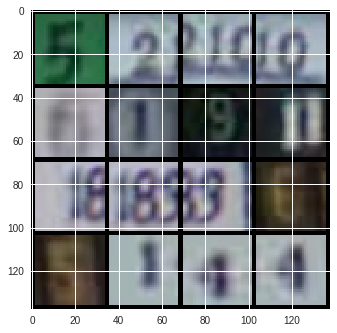

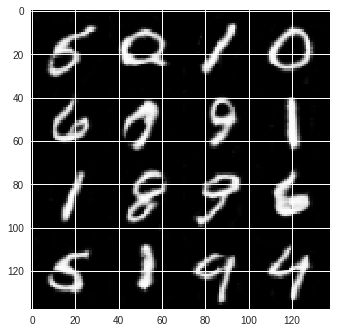

Predicted_MNIST_Labels:  tensor([[5, 2, 1, 0, 6, 7, 5, 1, 1, 8, 9, 6, 5, 1, 9, 4, 1, 6, 3, 4, 2, 0, 4, 9,
         2, 5, 4, 1, 4, 2, 9, 3, 5, 6, 0, 1, 5, 1, 1, 2, 3, 4, 6, 8, 7, 8, 1, 2,
         0, 6, 9, 1, 5, 1, 9, 2, 9, 5, 1, 7, 2, 9, 8, 4, 1, 0, 6, 9, 3, 2, 3, 5,
         7, 1, 9, 6, 2, 9, 3, 1, 4, 1, 7, 1, 2, 7, 7, 1, 0, 7, 4, 4, 5, 4, 4, 2,
         7, 1, 7, 7, 4, 8, 2, 5, 2, 2, 3, 1, 5, 6, 3, 7, 6, 3, 0, 7, 2, 7, 9, 2,
         8, 8, 1, 7, 7, 9, 3, 9]], device='cuda:0')
Actual_SVHN_Labels:  tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1, 3,
        2, 5, 4, 1, 4, 2, 8, 3, 8, 6, 0, 1, 5, 1, 1, 2, 9, 1, 6, 9, 2, 6, 1, 2,
        0, 6, 9, 1, 5, 1, 9, 8, 1, 5, 1, 5, 2, 9, 2, 4, 1, 0, 6, 9, 3, 2, 3, 5,
        1, 1, 4, 6, 2, 8, 3, 1, 4, 1, 7, 1, 2, 1, 7, 1, 0, 1, 4, 4, 6, 4, 4, 2,
        8, 1, 7, 7, 4, 8, 2, 3, 2, 2, 3, 1, 8, 6, 3, 7, 6, 3, 0, 7, 2, 7, 4, 2,
        8, 8, 1, 7, 1, 9, 3, 4], device='cuda:0')


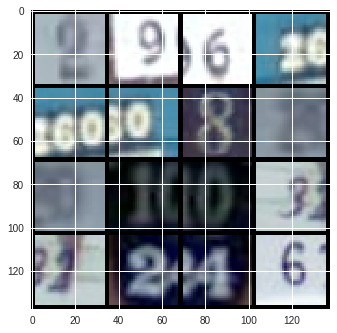

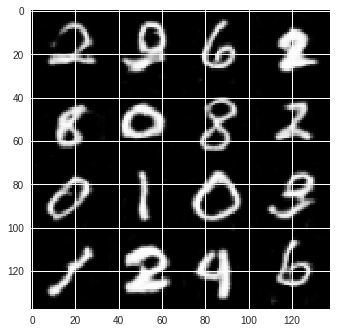

Predicted_MNIST_Labels:  tensor([[2, 3, 6, 2, 8, 0, 8, 2, 2, 1, 0, 3, 8, 2, 9, 6, 7, 2, 8, 3, 5, 3, 1, 5,
         9, 1, 8, 0, 5, 6, 9, 6, 4, 9, 3, 6, 1, 9, 4, 9, 5, 2, 7, 3, 3, 2, 1, 4,
         2, 9, 6, 7, 1, 0, 2, 1, 4, 8, 3, 2, 1, 8, 2, 6, 1, 7, 7, 3, 6, 7, 1, 3,
         7, 7, 7, 5, 6, 2, 7, 0, 4, 7, 8, 0, 2, 3, 7, 3, 8, 8, 8, 2, 0, 2, 7, 7,
         3, 9, 3, 2, 2, 9, 2, 5, 7, 4, 2, 9, 7, 6, 9, 3, 7, 6, 8, 9, 1, 7, 3, 0,
         3, 6, 9, 4, 0, 8, 3, 3]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 9, 6, 2, 6, 0, 8, 2, 0, 1, 0, 3, 2, 2, 4, 6, 7, 2, 1, 3, 5, 3, 1, 5,
        9, 1, 8, 1, 2, 6, 4, 6, 4, 9, 3, 6, 1, 0, 1, 2, 5, 2, 7, 5, 2, 2, 1, 4,
        2, 9, 6, 7, 1, 0, 2, 1, 4, 8, 3, 2, 1, 6, 2, 6, 1, 1, 2, 3, 6, 1, 1, 3,
        7, 2, 3, 5, 6, 2, 1, 0, 4, 7, 1, 0, 2, 3, 7, 3, 1, 1, 1, 2, 0, 1, 7, 1,
        2, 9, 1, 2, 2, 9, 2, 5, 7, 6, 1, 1, 4, 9, 6, 2, 7, 1, 1, 4, 1, 7, 3, 0,
        3, 6, 9, 4, 0, 3, 2, 3], device='cuda:0')


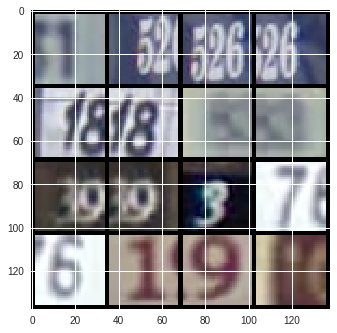

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fb1de07e400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


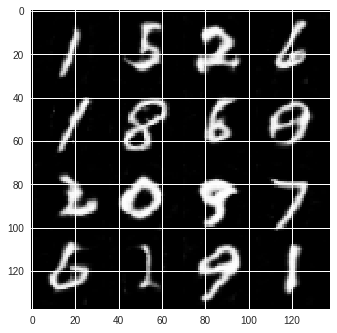

Predicted_MNIST_Labels:  tensor([[1, 5, 2, 6, 4, 8, 6, 9, 2, 0, 9, 7, 6, 2, 9, 1, 0, 3, 5, 2, 3, 8, 0, 1,
         9, 9, 5, 5, 8, 9, 5, 9, 3, 0, 3, 2, 9, 0, 7, 4, 2, 9, 8, 6, 7, 3, 9, 2,
         7, 0, 5, 4, 5, 5, 2, 8, 9, 3, 6, 1, 0, 8, 7, 2, 2, 1, 4, 2, 6, 1, 6, 6,
         5, 0, 2, 6, 9, 1, 2, 9, 2, 1, 3, 7, 0, 9, 4, 5, 6, 9, 2, 3, 3, 6, 2, 9,
         9, 4, 2, 5, 1, 6, 8, 9, 3, 7, 9, 6, 8, 9, 2, 0, 2, 9, 6, 9, 6, 8, 5, 2,
         5, 6, 5, 0, 6, 7, 4, 8]], device='cuda:0')
Actual_SVHN_Labels:  tensor([1, 5, 2, 6, 1, 8, 8, 3, 3, 9, 3, 7, 6, 1, 9, 1, 0, 3, 8, 2, 3, 1, 0, 1,
        9, 2, 5, 5, 8, 9, 5, 9, 1, 0, 3, 2, 1, 8, 7, 1, 2, 9, 8, 6, 7, 2, 9, 2,
        1, 5, 5, 4, 5, 3, 2, 8, 9, 3, 6, 1, 0, 8, 7, 2, 2, 1, 4, 2, 6, 1, 6, 6,
        5, 0, 2, 6, 4, 1, 2, 9, 2, 1, 3, 7, 9, 4, 4, 5, 6, 9, 6, 2, 3, 6, 2, 9,
        9, 4, 2, 5, 1, 6, 1, 4, 7, 7, 2, 6, 6, 9, 2, 0, 2, 1, 6, 9, 6, 2, 4, 2,
        5, 6, 3, 0, 6, 7, 4, 8], device='cuda:0')


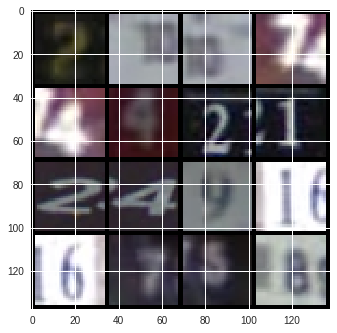

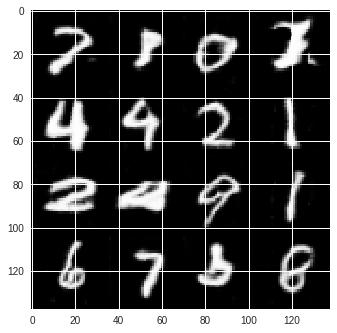

Predicted_MNIST_Labels:  tensor([[2, 3, 0, 3, 4, 9, 2, 1, 2, 4, 9, 1, 6, 7, 5, 6, 9, 9, 6, 3, 3, 2, 5, 1,
         2, 6, 3, 6, 6, 2, 6, 5, 3, 3, 2, 8, 4, 2, 7, 4, 8, 4, 3, 1, 4, 1, 4, 1,
         7, 5, 8, 7, 9, 0, 4, 5, 4, 7, 9, 5, 4, 2, 4, 8, 7, 7, 5, 9, 1, 8, 2, 7,
         2, 7, 3, 5, 3, 2, 5, 0, 7, 4, 3, 3, 4, 5, 3, 1, 8, 2, 1, 2, 1, 2, 7, 2,
         3, 3, 3, 1, 1, 2, 3, 4, 9, 3, 1, 3, 7, 4, 0, 6, 3, 6, 6, 2, 9, 1, 9, 9,
         0, 1, 5, 4, 7, 1, 5, 5]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 1, 0, 7, 4, 4, 2, 1, 2, 4, 9, 1, 6, 7, 5, 8, 9, 9, 6, 3, 3, 2, 5, 1,
        2, 1, 2, 6, 6, 2, 6, 5, 3, 1, 2, 8, 4, 2, 3, 4, 8, 4, 3, 1, 4, 1, 4, 1,
        7, 5, 8, 7, 1, 0, 4, 5, 4, 7, 9, 3, 1, 2, 4, 2, 7, 1, 3, 9, 1, 8, 2, 7,
        1, 7, 3, 5, 3, 2, 2, 6, 7, 4, 9, 3, 4, 3, 3, 4, 2, 2, 1, 2, 1, 2, 7, 2,
        3, 3, 3, 1, 1, 4, 3, 4, 3, 3, 1, 3, 7, 1, 0, 2, 3, 6, 6, 2, 9, 1, 8, 3,
        0, 1, 5, 4, 7, 1, 5, 5], device='cuda:0')


FileNotFoundError: ignored

In [0]:
dig.model_test()

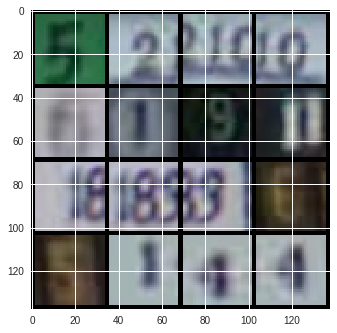

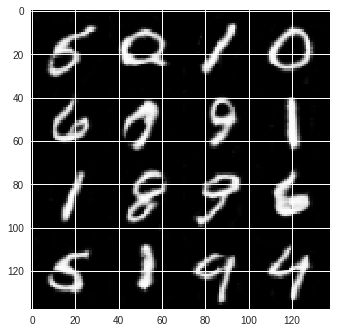

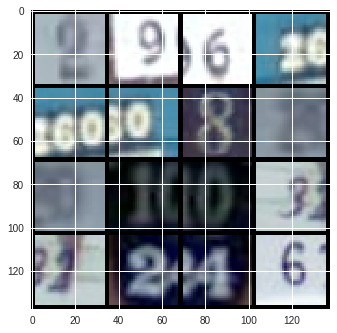

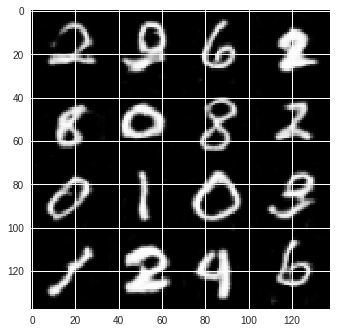

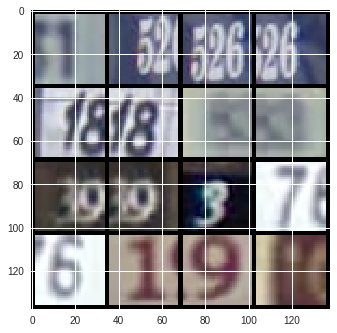

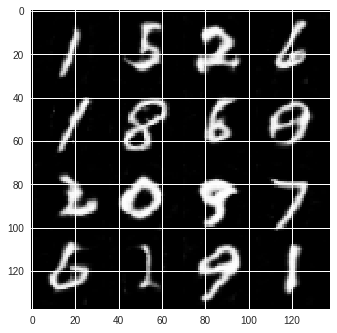

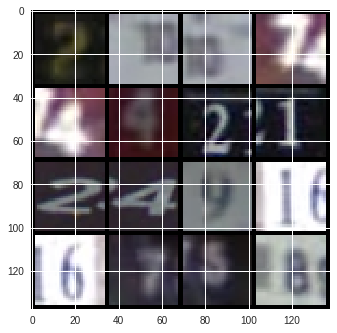

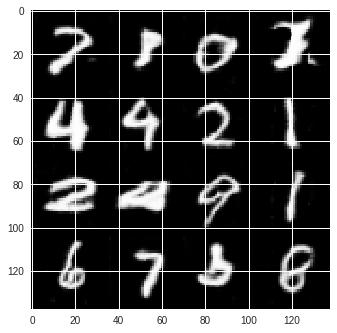

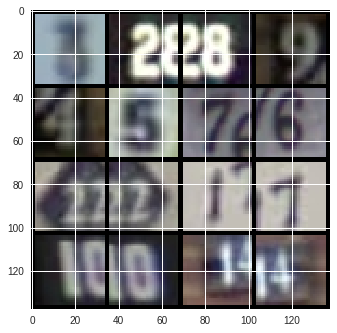

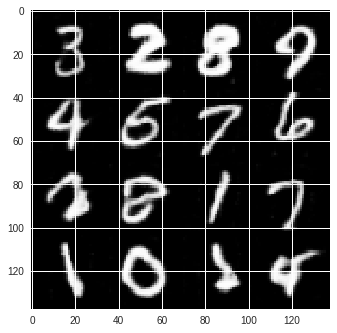

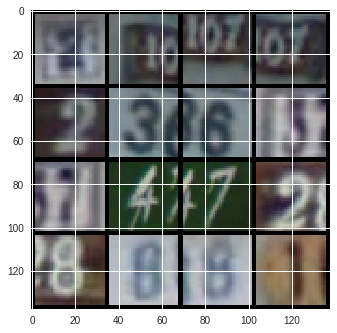

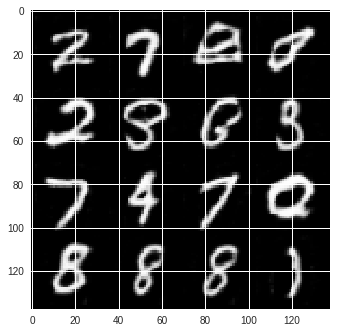

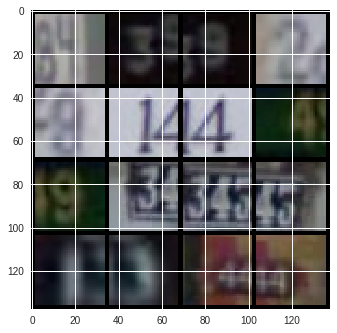

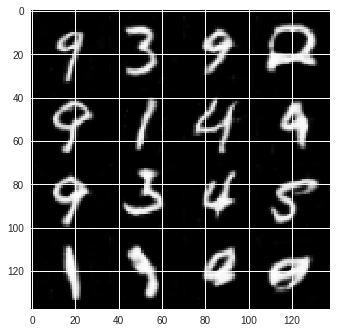

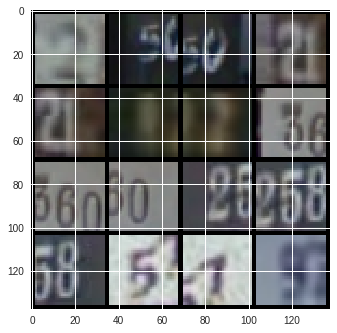

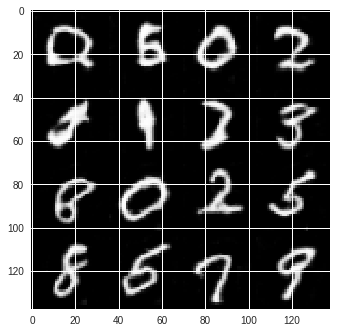

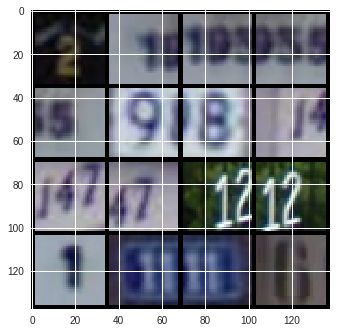

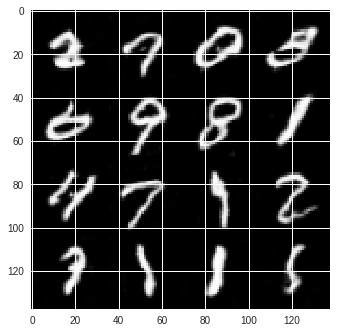

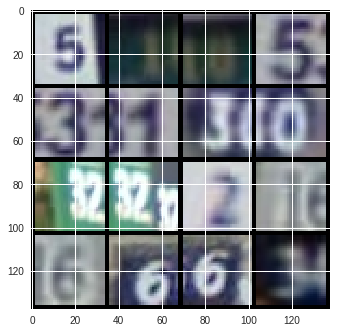

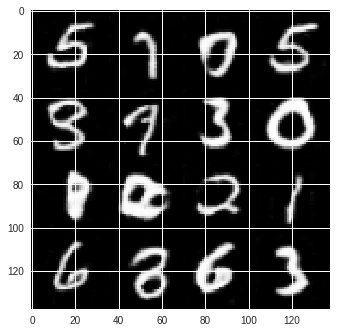

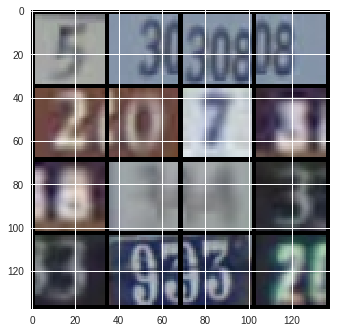

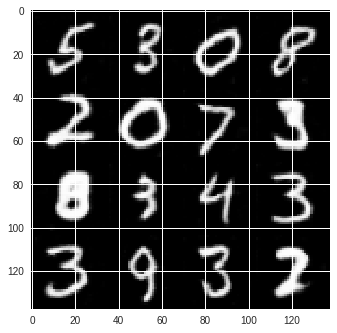

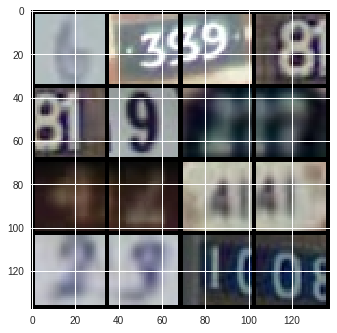

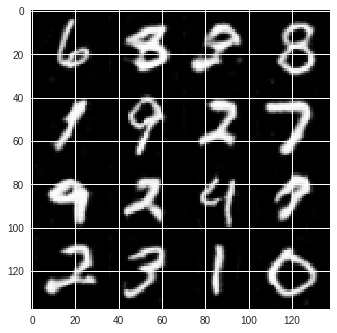

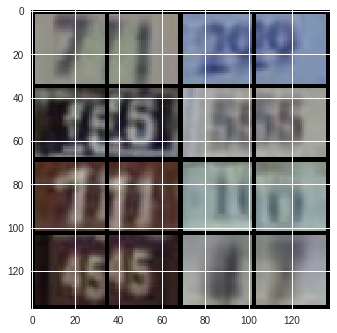

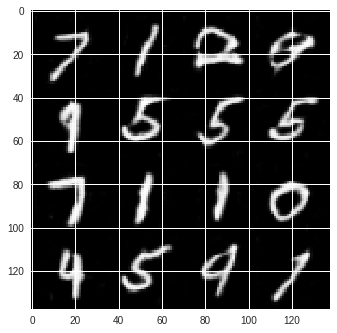

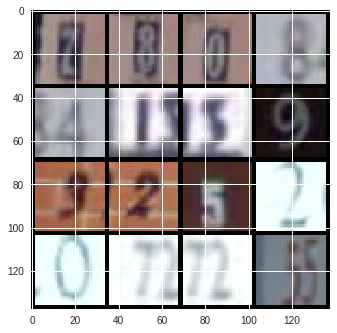

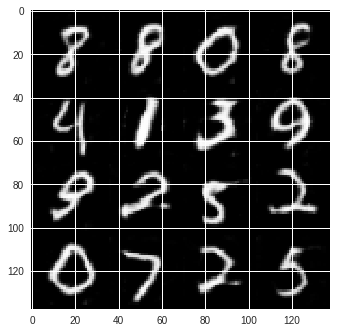

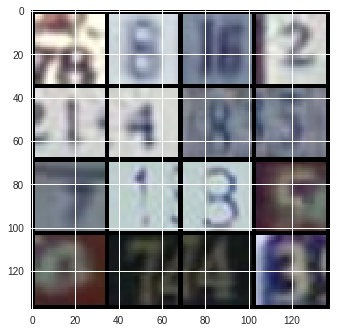

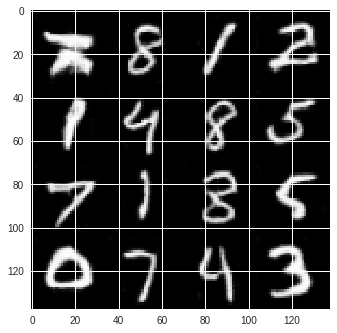

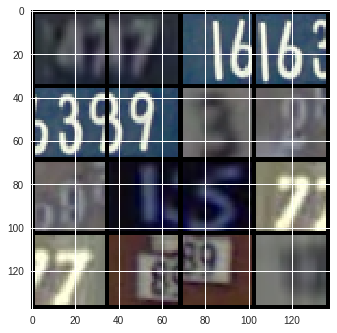

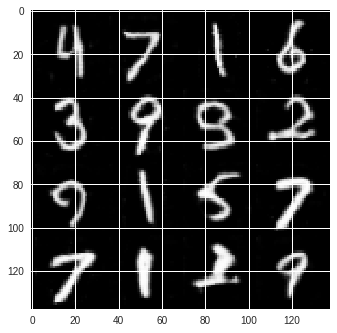

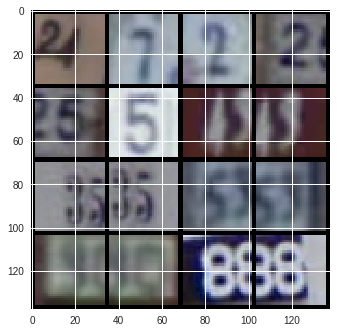

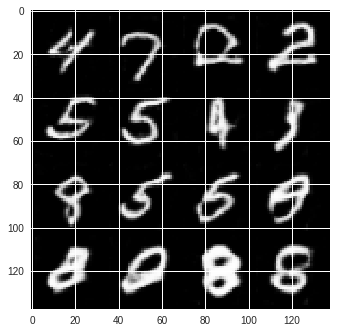

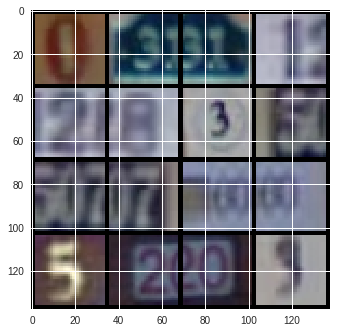

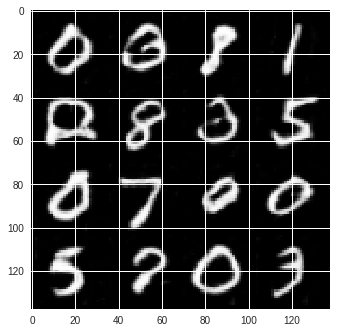

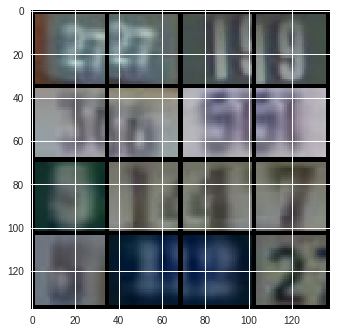

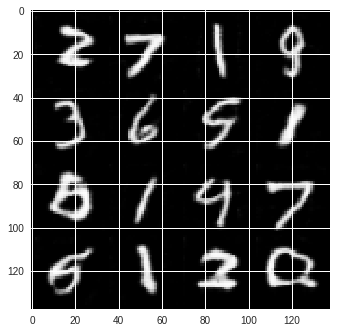

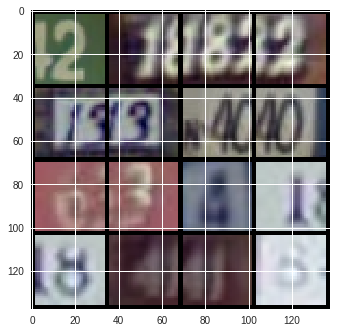

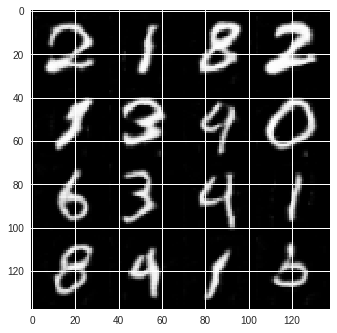

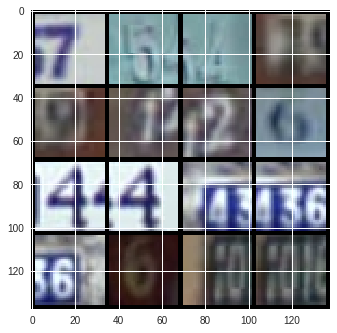

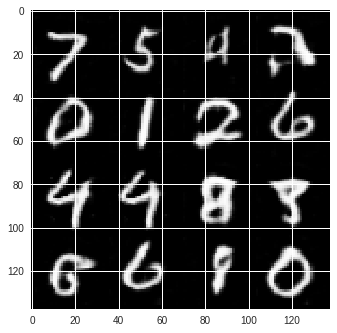

Not equal
Test Results on MNIST classifier:
 loss 0.0000  accuracy: 77.677%
total:  26032 correct:  tensor(20221, device='cuda:0')


In [0]:
dig.model_test()

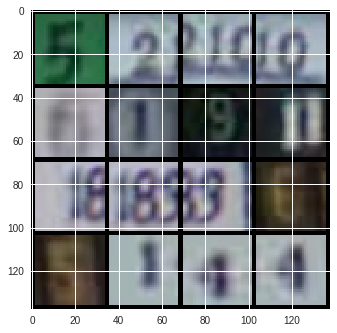

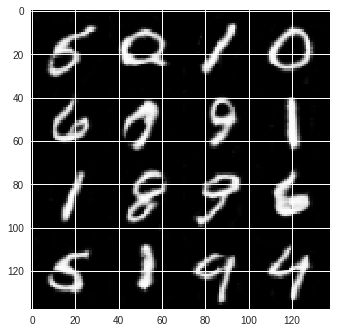

Predicted_MNIST_Labels:  tensor([[5, 2, 1, 0, 6, 7, 5, 1, 1, 8, 9, 6, 5, 1, 9, 4, 1, 6, 3, 4, 2, 0, 4, 9,
         2, 5, 4, 1, 4, 2, 9, 3, 5, 6, 0, 1, 5, 1, 1, 2, 3, 4, 6, 8, 7, 8, 1, 2,
         0, 6, 9, 1, 5, 1, 9, 2, 9, 5, 1, 7, 2, 9, 8, 4, 1, 0, 6, 9, 3, 2, 3, 5,
         7, 1, 9, 6, 2, 9, 3, 1, 4, 1, 7, 1, 2, 7, 7, 1, 0, 7, 4, 4, 5, 4, 4, 2,
         7, 1, 7, 7, 4, 8, 2, 5, 2, 2, 3, 1, 5, 6, 3, 7, 6, 3, 0, 7, 2, 7, 9, 2,
         8, 8, 1, 7, 7, 9, 3, 9]], device='cuda:0')
Actual_SVHN_Labels:  tensor([5, 2, 1, 0, 6, 1, 9, 1, 1, 8, 3, 6, 5, 1, 4, 4, 1, 6, 3, 4, 2, 0, 1, 3,
        2, 5, 4, 1, 4, 2, 8, 3, 8, 6, 0, 1, 5, 1, 1, 2, 9, 1, 6, 9, 2, 6, 1, 2,
        0, 6, 9, 1, 5, 1, 9, 8, 1, 5, 1, 5, 2, 9, 2, 4, 1, 0, 6, 9, 3, 2, 3, 5,
        1, 1, 4, 6, 2, 8, 3, 1, 4, 1, 7, 1, 2, 1, 7, 1, 0, 1, 4, 4, 6, 4, 4, 2,
        8, 1, 7, 7, 4, 8, 2, 3, 2, 2, 3, 1, 8, 6, 3, 7, 6, 3, 0, 7, 2, 7, 4, 2,
        8, 8, 1, 7, 1, 9, 3, 4], device='cuda:0')


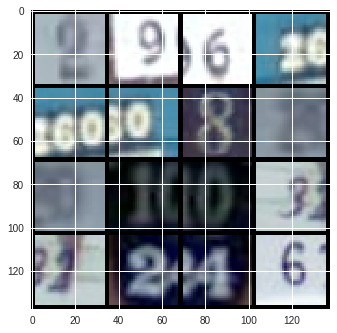

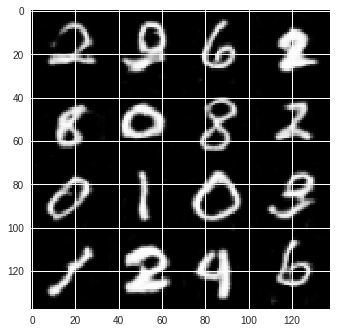

Predicted_MNIST_Labels:  tensor([[2, 3, 6, 2, 8, 0, 8, 2, 2, 1, 0, 3, 8, 2, 9, 6, 7, 2, 8, 3, 5, 3, 1, 5,
         9, 1, 8, 0, 5, 6, 9, 6, 4, 9, 3, 6, 1, 9, 4, 9, 5, 2, 7, 3, 3, 2, 1, 4,
         2, 9, 6, 7, 1, 0, 2, 1, 4, 8, 3, 2, 1, 8, 2, 6, 1, 7, 7, 3, 6, 7, 1, 3,
         7, 7, 7, 5, 6, 2, 7, 0, 4, 7, 8, 0, 2, 3, 7, 3, 8, 8, 8, 2, 0, 2, 7, 7,
         3, 9, 3, 2, 2, 9, 2, 5, 7, 4, 2, 9, 7, 6, 9, 3, 7, 6, 8, 9, 1, 7, 3, 0,
         3, 6, 9, 4, 0, 8, 3, 3]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 9, 6, 2, 6, 0, 8, 2, 0, 1, 0, 3, 2, 2, 4, 6, 7, 2, 1, 3, 5, 3, 1, 5,
        9, 1, 8, 1, 2, 6, 4, 6, 4, 9, 3, 6, 1, 0, 1, 2, 5, 2, 7, 5, 2, 2, 1, 4,
        2, 9, 6, 7, 1, 0, 2, 1, 4, 8, 3, 2, 1, 6, 2, 6, 1, 1, 2, 3, 6, 1, 1, 3,
        7, 2, 3, 5, 6, 2, 1, 0, 4, 7, 1, 0, 2, 3, 7, 3, 1, 1, 1, 2, 0, 1, 7, 1,
        2, 9, 1, 2, 2, 9, 2, 5, 7, 6, 1, 1, 4, 9, 6, 2, 7, 1, 1, 4, 1, 7, 3, 0,
        3, 6, 9, 4, 0, 3, 2, 3], device='cuda:0')


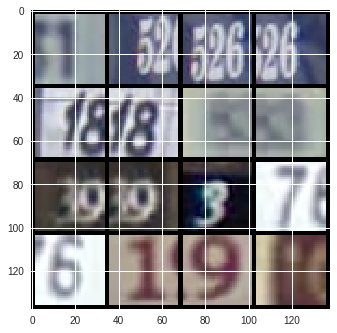

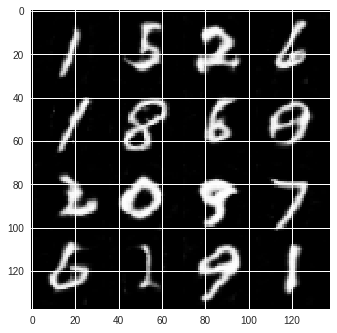

Predicted_MNIST_Labels:  tensor([[1, 5, 2, 6, 4, 8, 6, 9, 2, 0, 9, 7, 6, 2, 9, 1, 0, 3, 5, 2, 3, 8, 0, 1,
         9, 9, 5, 5, 8, 9, 5, 9, 3, 0, 3, 2, 9, 0, 7, 4, 2, 9, 8, 6, 7, 3, 9, 2,
         7, 0, 5, 4, 5, 5, 2, 8, 9, 3, 6, 1, 0, 8, 7, 2, 2, 1, 4, 2, 6, 1, 6, 6,
         5, 0, 2, 6, 9, 1, 2, 9, 2, 1, 3, 7, 0, 9, 4, 5, 6, 9, 2, 3, 3, 6, 2, 9,
         9, 4, 2, 5, 1, 6, 8, 9, 3, 7, 9, 6, 8, 9, 2, 0, 2, 9, 6, 9, 6, 8, 5, 2,
         5, 6, 5, 0, 6, 7, 4, 8]], device='cuda:0')
Actual_SVHN_Labels:  tensor([1, 5, 2, 6, 1, 8, 8, 3, 3, 9, 3, 7, 6, 1, 9, 1, 0, 3, 8, 2, 3, 1, 0, 1,
        9, 2, 5, 5, 8, 9, 5, 9, 1, 0, 3, 2, 1, 8, 7, 1, 2, 9, 8, 6, 7, 2, 9, 2,
        1, 5, 5, 4, 5, 3, 2, 8, 9, 3, 6, 1, 0, 8, 7, 2, 2, 1, 4, 2, 6, 1, 6, 6,
        5, 0, 2, 6, 4, 1, 2, 9, 2, 1, 3, 7, 9, 4, 4, 5, 6, 9, 6, 2, 3, 6, 2, 9,
        9, 4, 2, 5, 1, 6, 1, 4, 7, 7, 2, 6, 6, 9, 2, 0, 2, 1, 6, 9, 6, 2, 4, 2,
        5, 6, 3, 0, 6, 7, 4, 8], device='cuda:0')


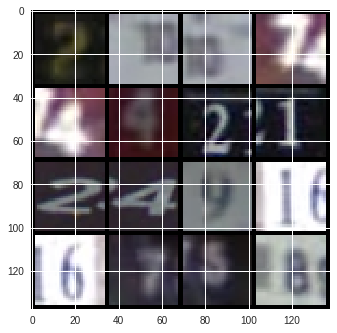

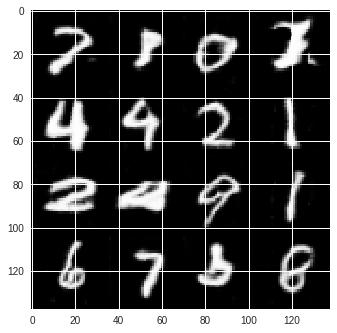

Predicted_MNIST_Labels:  tensor([[2, 3, 0, 3, 4, 9, 2, 1, 2, 4, 9, 1, 6, 7, 5, 6, 9, 9, 6, 3, 3, 2, 5, 1,
         2, 6, 3, 6, 6, 2, 6, 5, 3, 3, 2, 8, 4, 2, 7, 4, 8, 4, 3, 1, 4, 1, 4, 1,
         7, 5, 8, 7, 9, 0, 4, 5, 4, 7, 9, 5, 4, 2, 4, 8, 7, 7, 5, 9, 1, 8, 2, 7,
         2, 7, 3, 5, 3, 2, 5, 0, 7, 4, 3, 3, 4, 5, 3, 1, 8, 2, 1, 2, 1, 2, 7, 2,
         3, 3, 3, 1, 1, 2, 3, 4, 9, 3, 1, 3, 7, 4, 0, 6, 3, 6, 6, 2, 9, 1, 9, 9,
         0, 1, 5, 4, 7, 1, 5, 5]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 1, 0, 7, 4, 4, 2, 1, 2, 4, 9, 1, 6, 7, 5, 8, 9, 9, 6, 3, 3, 2, 5, 1,
        2, 1, 2, 6, 6, 2, 6, 5, 3, 1, 2, 8, 4, 2, 3, 4, 8, 4, 3, 1, 4, 1, 4, 1,
        7, 5, 8, 7, 1, 0, 4, 5, 4, 7, 9, 3, 1, 2, 4, 2, 7, 1, 3, 9, 1, 8, 2, 7,
        1, 7, 3, 5, 3, 2, 2, 6, 7, 4, 9, 3, 4, 3, 3, 4, 2, 2, 1, 2, 1, 2, 7, 2,
        3, 3, 3, 1, 1, 4, 3, 4, 3, 3, 1, 3, 7, 1, 0, 2, 3, 6, 6, 2, 9, 1, 8, 3,
        0, 1, 5, 4, 7, 1, 5, 5], device='cuda:0')


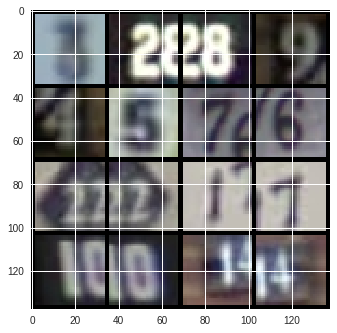

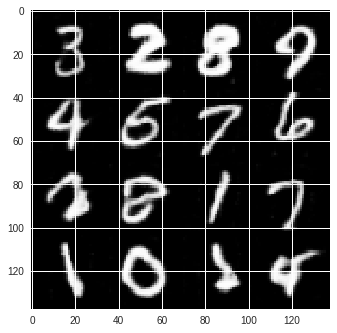

Predicted_MNIST_Labels:  tensor([[3, 2, 8, 9, 4, 5, 3, 6, 2, 3, 1, 7, 1, 0, 1, 5, 7, 7, 3, 3, 5, 4, 2, 8,
         2, 3, 2, 1, 6, 9, 2, 5, 4, 0, 2, 9, 9, 1, 9, 5, 7, 4, 5, 6, 2, 4, 0, 1,
         5, 2, 0, 5, 5, 8, 5, 7, 8, 5, 9, 5, 3, 7, 2, 4, 3, 7, 5, 0, 4, 3, 2, 9,
         9, 6, 2, 1, 3, 4, 8, 3, 3, 1, 9, 2, 5, 2, 4, 0, 9, 1, 6, 7, 0, 9, 2, 0,
         5, 2, 9, 0, 8, 1, 0, 2, 0, 7, 9, 7, 7, 2, 5, 5, 6, 3, 5, 1, 3, 2, 7, 5,
         1, 3, 8, 7, 7, 1, 5, 1]], device='cuda:0')
Actual_SVHN_Labels:  tensor([3, 2, 8, 9, 4, 5, 7, 6, 2, 2, 1, 7, 1, 0, 1, 4, 4, 7, 3, 1, 5, 4, 2, 1,
        2, 1, 2, 1, 6, 9, 2, 5, 4, 0, 2, 2, 3, 1, 9, 5, 7, 4, 5, 8, 2, 4, 0, 1,
        5, 2, 0, 5, 5, 8, 5, 7, 6, 5, 9, 5, 3, 7, 2, 4, 2, 7, 3, 0, 4, 3, 2, 1,
        9, 6, 2, 1, 3, 4, 5, 3, 3, 1, 9, 2, 6, 2, 4, 0, 9, 1, 6, 1, 0, 9, 2, 0,
        5, 2, 4, 0, 8, 1, 0, 2, 0, 1, 9, 7, 7, 2, 5, 5, 6, 1, 5, 1, 2, 2, 7, 5,
        1, 3, 1, 7, 7, 1, 5, 1], device='cuda:0')


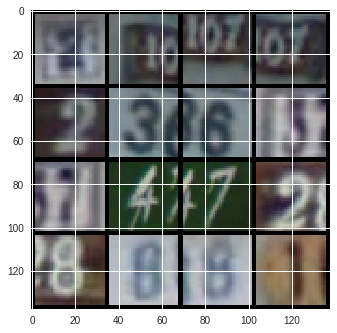

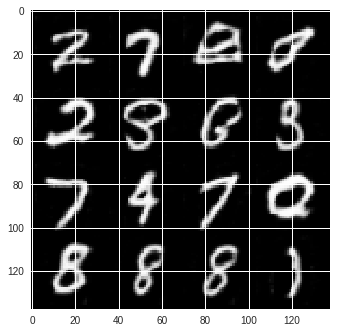

Predicted_MNIST_Labels:  tensor([[2, 7, 2, 3, 2, 8, 6, 3, 7, 4, 7, 2, 8, 8, 8, 3, 6, 3, 7, 7, 7, 5, 8, 5,
         4, 2, 7, 3, 7, 2, 7, 8, 0, 5, 0, 5, 9, 7, 9, 1, 7, 8, 4, 1, 2, 7, 6, 2,
         5, 1, 1, 5, 9, 4, 9, 4, 8, 1, 2, 2, 8, 5, 2, 0, 6, 2, 6, 8, 3, 8, 3, 5,
         7, 2, 7, 3, 3, 8, 2, 0, 1, 2, 1, 2, 4, 2, 5, 5, 2, 1, 1, 6, 1, 3, 5, 2,
         9, 4, 4, 1, 3, 1, 1, 1, 0, 0, 7, 1, 8, 5, 4, 8, 5, 6, 4, 9, 3, 0, 6, 8,
         3, 8, 2, 3, 6, 9, 1, 5]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 7, 1, 0, 2, 3, 6, 3, 7, 4, 7, 2, 8, 8, 8, 1, 6, 3, 7, 1, 1, 5, 8, 5,
        4, 2, 7, 3, 9, 2, 7, 8, 0, 3, 0, 5, 9, 7, 9, 1, 7, 8, 4, 1, 2, 7, 6, 2,
        8, 1, 1, 5, 9, 4, 9, 4, 0, 1, 2, 2, 1, 5, 2, 6, 6, 2, 6, 8, 3, 8, 3, 3,
        7, 2, 7, 3, 3, 8, 2, 0, 1, 0, 1, 2, 4, 2, 3, 8, 2, 1, 1, 6, 1, 3, 5, 2,
        4, 4, 4, 1, 3, 1, 1, 1, 0, 2, 7, 1, 8, 5, 4, 3, 8, 6, 4, 4, 3, 0, 6, 1,
        7, 8, 2, 3, 1, 9, 1, 8], device='cuda:0')


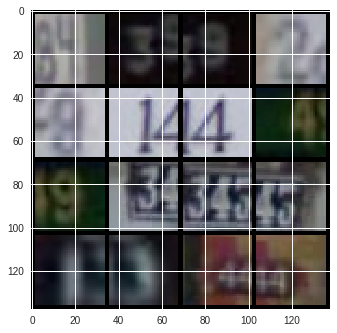

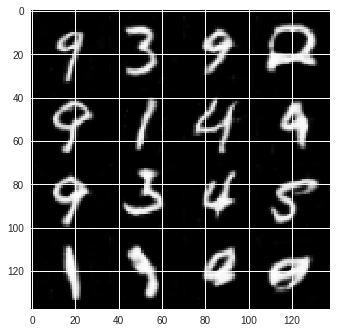

Predicted_MNIST_Labels:  tensor([[9, 3, 9, 2, 9, 1, 4, 4, 9, 3, 4, 5, 1, 3, 4, 4, 6, 1, 1, 1, 0, 1, 6, 9,
         1, 1, 5, 9, 2, 0, 3, 9, 3, 6, 1, 2, 8, 0, 0, 9, 9, 3, 6, 7, 2, 9, 0, 5,
         1, 3, 4, 1, 5, 5, 3, 6, 9, 0, 2, 9, 6, 5, 5, 7, 2, 7, 4, 0, 5, 5, 7, 3,
         7, 8, 2, 6, 2, 5, 3, 3, 9, 5, 2, 9, 1, 0, 1, 5, 1, 5, 1, 5, 6, 2, 0, 9,
         0, 4, 1, 9, 5, 3, 9, 1, 0, 5, 0, 0, 3, 8, 1, 1, 3, 1, 6, 4, 6, 3, 0, 2,
         7, 8, 6, 2, 6, 1, 8, 5]], device='cuda:0')
Actual_SVHN_Labels:  tensor([4, 3, 9, 2, 9, 1, 4, 4, 9, 3, 4, 5, 1, 3, 4, 4, 6, 1, 1, 1, 0, 1, 6, 9,
        1, 1, 5, 5, 7, 0, 3, 9, 3, 6, 1, 2, 3, 2, 0, 8, 1, 3, 6, 7, 2, 9, 0, 2,
        1, 7, 4, 1, 5, 5, 0, 6, 3, 0, 2, 3, 6, 2, 6, 1, 2, 2, 1, 0, 5, 5, 7, 3,
        7, 8, 2, 6, 2, 5, 3, 3, 4, 5, 2, 9, 1, 0, 1, 8, 1, 5, 1, 5, 6, 8, 0, 1,
        0, 4, 1, 3, 5, 3, 3, 1, 0, 3, 4, 4, 1, 8, 1, 1, 3, 1, 6, 4, 0, 3, 5, 2,
        0, 8, 6, 2, 6, 1, 8, 5], device='cuda:0')


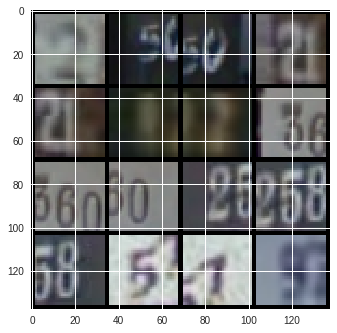

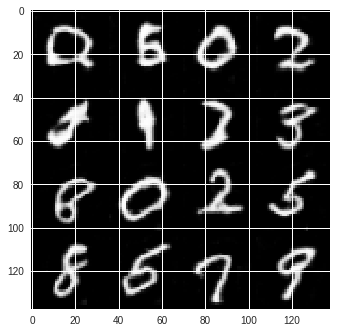

Predicted_MNIST_Labels:  tensor([[2, 5, 0, 2, 3, 9, 3, 3, 8, 0, 2, 5, 8, 5, 7, 9, 7, 6, 8, 5, 2, 2, 1, 3,
         2, 8, 4, 1, 9, 4, 2, 4, 0, 8, 2, 3, 2, 3, 7, 2, 3, 4, 2, 0, 0, 3, 3, 3,
         9, 2, 8, 5, 3, 6, 8, 6, 1, 9, 9, 1, 0, 6, 5, 1, 0, 7, 2, 7, 3, 0, 1, 7,
         7, 2, 2, 2, 8, 1, 1, 0, 2, 3, 7, 3, 2, 7, 5, 8, 3, 9, 1, 9, 5, 2, 0, 8,
         1, 9, 1, 4, 1, 5, 1, 5, 5, 1, 9, 1, 8, 5, 7, 1, 4, 9, 6, 1, 0, 7, 4, 3,
         1, 5, 7, 6, 8, 9, 1, 4]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 5, 0, 2, 1, 1, 2, 3, 6, 0, 2, 5, 8, 5, 7, 9, 7, 6, 8, 5, 2, 2, 1, 7,
        2, 8, 4, 1, 9, 4, 2, 4, 0, 8, 2, 3, 2, 3, 7, 7, 3, 4, 2, 0, 0, 3, 3, 3,
        7, 2, 3, 5, 3, 6, 8, 6, 1, 6, 9, 1, 0, 6, 5, 1, 0, 7, 2, 7, 3, 0, 1, 9,
        3, 2, 2, 2, 5, 1, 1, 0, 2, 7, 7, 3, 2, 7, 2, 8, 3, 9, 1, 9, 5, 2, 0, 2,
        1, 4, 1, 4, 1, 5, 1, 5, 5, 1, 9, 1, 8, 5, 7, 1, 4, 8, 6, 1, 0, 3, 4, 3,
        1, 6, 7, 6, 8, 9, 1, 4], device='cuda:0')


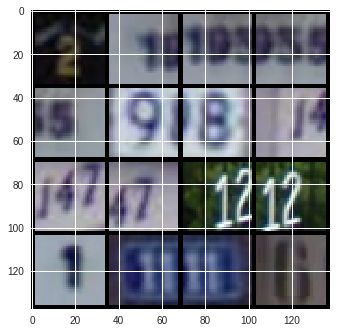

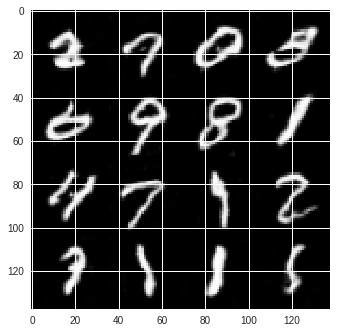

Predicted_MNIST_Labels:  tensor([[2, 7, 2, 5, 5, 9, 8, 1, 4, 3, 9, 3, 3, 1, 1, 5, 3, 2, 8, 4, 5, 2, 4, 7,
         8, 8, 9, 5, 5, 7, 8, 6, 7, 9, 3, 3, 6, 7, 5, 4, 4, 6, 1, 8, 9, 2, 0, 3,
         4, 7, 0, 5, 5, 7, 4, 1, 0, 1, 8, 2, 9, 1, 9, 3, 5, 5, 6, 8, 8, 8, 2, 0,
         7, 7, 3, 5, 0, 3, 2, 5, 2, 1, 4, 2, 2, 1, 1, 0, 3, 0, 9, 0, 9, 9, 9, 9,
         5, 7, 8, 1, 6, 3, 5, 1, 0, 7, 9, 0, 6, 2, 2, 6, 7, 4, 4, 3, 4, 3, 8, 9,
         0, 1, 1, 2, 9, 3, 1, 2]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 1, 9, 5, 5, 9, 8, 1, 4, 7, 1, 2, 1, 1, 1, 6, 0, 2, 8, 4, 5, 2, 4, 1,
        8, 8, 9, 5, 5, 7, 8, 6, 7, 9, 3, 3, 6, 7, 5, 4, 4, 6, 1, 7, 3, 2, 0, 3,
        4, 7, 0, 5, 5, 7, 1, 1, 0, 1, 6, 2, 9, 1, 4, 3, 5, 6, 4, 5, 8, 3, 2, 0,
        2, 7, 3, 5, 0, 3, 2, 5, 2, 1, 4, 2, 2, 1, 1, 0, 3, 0, 9, 0, 1, 0, 1, 9,
        5, 1, 8, 1, 6, 3, 8, 1, 0, 1, 4, 6, 6, 4, 3, 6, 1, 4, 4, 3, 4, 3, 8, 1,
        0, 1, 1, 2, 1, 3, 1, 2], device='cuda:0')


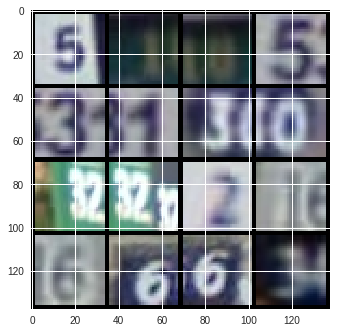

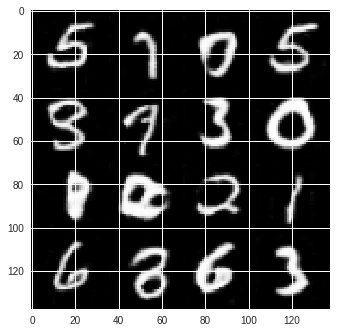

Predicted_MNIST_Labels:  tensor([[5, 7, 7, 5, 3, 7, 3, 0, 8, 2, 2, 1, 6, 8, 6, 3, 9, 8, 5, 2, 5, 9, 7, 3,
         9, 4, 0, 7, 7, 8, 4, 1, 9, 4, 6, 5, 3, 2, 5, 3, 7, 5, 1, 2, 7, 4, 4, 1,
         5, 2, 5, 8, 4, 2, 0, 9, 5, 8, 9, 7, 2, 5, 6, 3, 6, 5, 2, 4, 4, 6, 8, 2,
         7, 7, 5, 4, 8, 6, 3, 1, 2, 6, 9, 2, 5, 8, 2, 1, 9, 8, 5, 1, 9, 5, 1, 1,
         0, 6, 8, 5, 5, 2, 8, 2, 9, 1, 5, 7, 7, 2, 3, 5, 0, 5, 2, 9, 5, 6, 8, 5,
         3, 2, 9, 3, 7, 3, 9, 3]], device='cuda:0')
Actual_SVHN_Labels:  tensor([5, 1, 0, 5, 3, 1, 3, 0, 3, 2, 2, 1, 6, 6, 6, 3, 4, 8, 5, 2, 5, 4, 7, 8,
        9, 4, 0, 4, 2, 3, 4, 1, 9, 4, 6, 5, 3, 2, 5, 2, 7, 5, 1, 2, 9, 4, 4, 1,
        5, 2, 1, 8, 4, 1, 0, 3, 5, 8, 3, 7, 2, 5, 6, 3, 6, 6, 2, 4, 4, 6, 1, 2,
        2, 7, 5, 4, 8, 5, 3, 4, 2, 6, 9, 2, 5, 8, 2, 1, 9, 8, 8, 1, 8, 5, 1, 1,
        2, 6, 3, 3, 3, 2, 1, 2, 4, 1, 5, 2, 0, 2, 3, 5, 0, 5, 2, 4, 5, 6, 8, 5,
        3, 2, 9, 3, 1, 7, 4, 0], device='cuda:0')


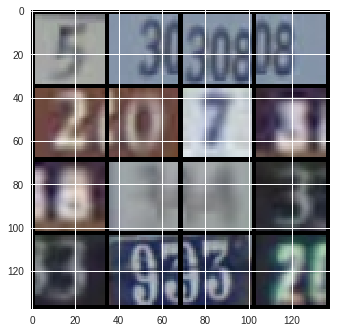

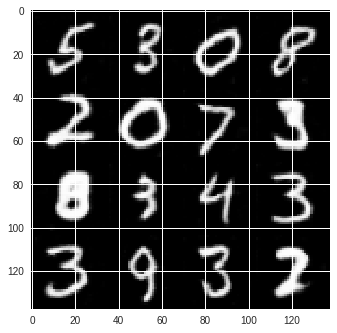

Predicted_MNIST_Labels:  tensor([[5, 3, 0, 8, 2, 0, 7, 3, 8, 3, 4, 3, 3, 9, 3, 2, 0, 8, 6, 3, 1, 8, 7, 4,
         2, 1, 4, 9, 2, 5, 4, 2, 8, 1, 7, 2, 4, 5, 0, 4, 1, 1, 6, 0, 0, 5, 9, 1,
         8, 4, 2, 5, 7, 1, 0, 9, 8, 2, 3, 5, 4, 6, 1, 3, 0, 4, 2, 6, 1, 2, 3, 1,
         6, 2, 6, 9, 8, 2, 9, 7, 0, 1, 3, 9, 0, 2, 9, 1, 9, 3, 0, 1, 0, 8, 5, 6,
         7, 0, 3, 2, 4, 5, 2, 3, 9, 6, 8, 9, 1, 2, 2, 2, 7, 0, 4, 9, 6, 5, 1, 0,
         0, 3, 8, 5, 2, 2, 9, 9]], device='cuda:0')
Actual_SVHN_Labels:  tensor([5, 3, 0, 8, 2, 0, 7, 3, 8, 3, 4, 3, 3, 9, 3, 2, 0, 8, 6, 3, 1, 8, 1, 4,
        2, 1, 4, 9, 2, 5, 4, 2, 8, 1, 7, 2, 4, 1, 5, 4, 1, 1, 6, 7, 4, 1, 8, 1,
        8, 4, 2, 5, 7, 1, 0, 3, 2, 2, 3, 5, 4, 3, 1, 3, 0, 4, 2, 8, 1, 2, 1, 1,
        6, 6, 6, 2, 7, 2, 2, 1, 0, 1, 3, 1, 0, 2, 9, 1, 1, 3, 7, 1, 0, 8, 8, 6,
        7, 8, 3, 2, 4, 5, 2, 1, 9, 6, 2, 9, 1, 2, 2, 2, 7, 0, 4, 9, 6, 5, 1, 9,
        0, 3, 1, 5, 2, 2, 8, 4], device='cuda:0')


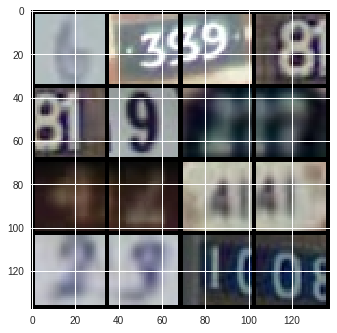

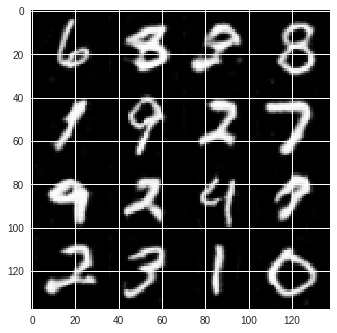

Predicted_MNIST_Labels:  tensor([[6, 8, 5, 8, 9, 9, 2, 7, 9, 2, 4, 7, 2, 3, 1, 0, 8, 4, 4, 4, 9, 1, 2, 2,
         5, 1, 1, 5, 6, 1, 4, 5, 4, 1, 3, 5, 1, 3, 5, 4, 2, 2, 1, 5, 7, 6, 0, 1,
         7, 9, 9, 2, 8, 3, 9, 8, 5, 8, 1, 6, 0, 2, 5, 9, 4, 1, 0, 1, 9, 3, 4, 1,
         3, 2, 5, 7, 3, 5, 2, 7, 2, 7, 5, 3, 1, 3, 8, 7, 1, 9, 0, 3, 5, 3, 1, 7,
         9, 7, 5, 8, 8, 8, 5, 4, 2, 7, 2, 8, 3, 9, 5, 2, 4, 8, 7, 5, 0, 7, 5, 1,
         3, 1, 8, 0, 6, 7, 4, 9]], device='cuda:0')
Actual_SVHN_Labels:  tensor([6, 3, 9, 8, 1, 9, 2, 7, 4, 2, 4, 1, 2, 3, 1, 0, 8, 4, 4, 4, 3, 1, 2, 2,
        5, 1, 1, 3, 6, 1, 4, 5, 4, 1, 3, 5, 1, 1, 5, 1, 2, 2, 1, 5, 7, 6, 2, 3,
        7, 9, 4, 2, 6, 3, 9, 8, 5, 8, 1, 6, 0, 9, 0, 1, 4, 1, 0, 1, 9, 2, 4, 1,
        3, 2, 8, 7, 3, 8, 3, 2, 2, 7, 1, 3, 1, 3, 8, 5, 1, 9, 0, 3, 3, 3, 1, 1,
        9, 7, 5, 1, 2, 1, 5, 1, 2, 1, 2, 1, 7, 8, 5, 2, 4, 1, 7, 5, 9, 7, 5, 1,
        3, 1, 8, 0, 6, 7, 4, 3], device='cuda:0')


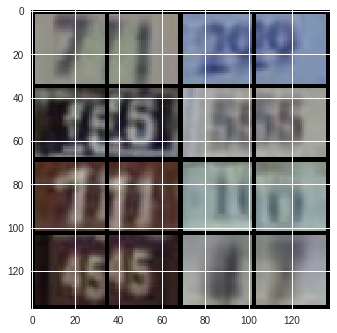

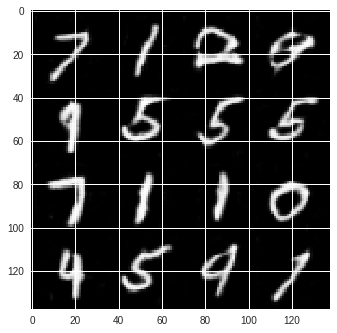

Predicted_MNIST_Labels:  tensor([[7, 1, 2, 8, 9, 5, 5, 5, 7, 1, 1, 0, 4, 5, 4, 7, 9, 3, 1, 2, 8, 1, 3, 5,
         3, 7, 6, 3, 7, 5, 7, 2, 1, 6, 9, 8, 3, 8, 5, 2, 9, 0, 9, 4, 2, 0, 7, 5,
         8, 1, 4, 5, 3, 2, 9, 8, 7, 2, 4, 5, 4, 2, 0, 1, 3, 3, 3, 2, 4, 4, 9, 8,
         1, 0, 1, 6, 5, 8, 2, 6, 1, 0, 3, 0, 1, 4, 8, 1, 6, 5, 5, 3, 0, 3, 2, 3,
         4, 9, 1, 7, 3, 2, 9, 7, 0, 2, 7, 5, 8, 1, 4, 9, 3, 0, 3, 3, 1, 3, 8, 1,
         2, 1, 1, 4, 3, 1, 3, 4]], device='cuda:0')
Actual_SVHN_Labels:  tensor([7, 1, 2, 9, 1, 5, 5, 5, 7, 1, 1, 0, 4, 5, 4, 7, 4, 1, 1, 2, 8, 1, 3, 5,
        3, 7, 6, 3, 1, 3, 7, 2, 1, 6, 4, 8, 3, 8, 5, 2, 9, 0, 4, 1, 0, 0, 7, 2,
        2, 1, 4, 8, 8, 2, 9, 3, 7, 2, 4, 5, 4, 2, 0, 1, 3, 3, 3, 2, 4, 4, 1, 9,
        1, 0, 1, 6, 5, 8, 2, 6, 1, 0, 3, 0, 1, 4, 9, 1, 6, 9, 5, 3, 0, 3, 2, 3,
        4, 9, 1, 1, 7, 2, 0, 7, 0, 2, 7, 6, 8, 1, 4, 9, 2, 2, 3, 3, 1, 3, 8, 1,
        2, 1, 1, 4, 3, 1, 3, 4], device='cuda:0')


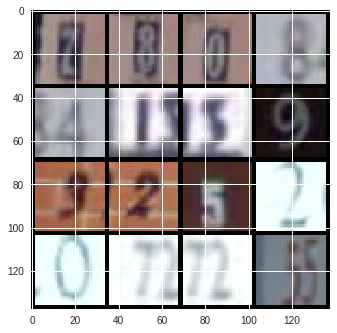

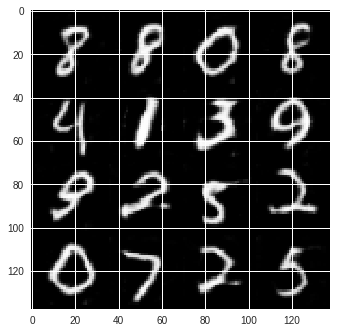

Predicted_MNIST_Labels:  tensor([[8, 8, 0, 8, 4, 1, 3, 9, 8, 2, 5, 2, 0, 7, 2, 5, 9, 7, 8, 1, 0, 3, 1, 1,
         3, 7, 9, 4, 6, 9, 0, 7, 8, 5, 3, 7, 2, 6, 5, 1, 3, 9, 5, 0, 1, 5, 8, 3,
         4, 5, 2, 8, 5, 9, 0, 1, 5, 2, 7, 8, 4, 5, 8, 8, 9, 6, 9, 7, 2, 4, 2, 4,
         8, 0, 3, 4, 2, 1, 6, 3, 6, 8, 1, 9, 5, 1, 3, 0, 8, 1, 3, 5, 8, 6, 5, 3,
         6, 2, 0, 3, 7, 6, 1, 3, 6, 7, 1, 2, 3, 0, 2, 9, 2, 2, 3, 7, 4, 5, 3, 1,
         9, 9, 2, 1, 2, 2, 1, 8]], device='cuda:0')
Actual_SVHN_Labels:  tensor([7, 8, 0, 8, 4, 1, 3, 9, 3, 2, 5, 2, 0, 7, 2, 5, 9, 7, 8, 1, 0, 3, 1, 1,
        3, 7, 9, 4, 6, 9, 0, 7, 3, 5, 3, 7, 2, 6, 8, 1, 3, 2, 5, 0, 1, 5, 8, 3,
        4, 5, 1, 1, 6, 4, 0, 1, 5, 2, 7, 8, 1, 5, 8, 8, 9, 6, 5, 7, 2, 1, 2, 4,
        3, 0, 3, 4, 2, 1, 1, 3, 6, 8, 1, 4, 5, 1, 3, 0, 8, 1, 1, 3, 1, 6, 5, 3,
        6, 2, 4, 1, 7, 6, 1, 3, 6, 7, 1, 2, 3, 0, 2, 8, 2, 2, 5, 7, 4, 5, 3, 1,
        1, 8, 2, 1, 2, 2, 1, 7], device='cuda:0')


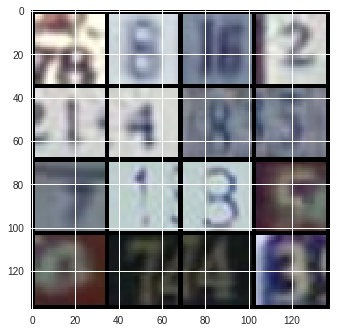

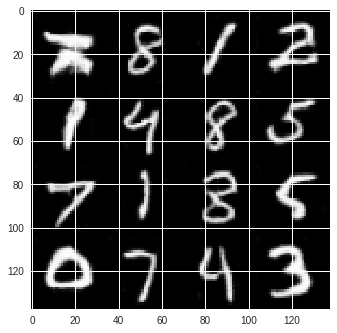

Predicted_MNIST_Labels:  tensor([[7, 8, 1, 2, 8, 4, 8, 5, 7, 1, 3, 5, 0, 7, 9, 3, 9, 4, 3, 9, 9, 9, 0, 7,
         2, 4, 4, 7, 1, 9, 1, 5, 2, 8, 8, 4, 6, 9, 4, 3, 2, 8, 2, 3, 5, 1, 0, 3,
         0, 9, 9, 9, 3, 1, 9, 7, 2, 2, 4, 1, 9, 8, 4, 1, 7, 7, 7, 6, 2, 3, 3, 5,
         9, 3, 0, 1, 8, 3, 3, 3, 6, 3, 9, 9, 5, 2, 6, 4, 5, 7, 4, 4, 7, 2, 0, 4,
         7, 2, 4, 8, 4, 5, 7, 8, 9, 5, 9, 9, 9, 0, 1, 5, 5, 1, 6, 7, 7, 2, 0, 1,
         9, 6, 9, 0, 9, 8, 2, 9]], device='cuda:0')
Actual_SVHN_Labels:  tensor([8, 8, 6, 2, 1, 4, 8, 5, 7, 1, 8, 5, 0, 7, 4, 3, 9, 1, 3, 5, 1, 9, 0, 7,
        2, 4, 4, 7, 1, 9, 1, 5, 2, 8, 8, 4, 6, 4, 4, 3, 2, 1, 2, 3, 5, 1, 0, 3,
        9, 4, 8, 3, 3, 1, 3, 7, 2, 2, 4, 1, 9, 9, 4, 1, 7, 1, 7, 6, 2, 3, 3, 5,
        9, 2, 0, 1, 8, 3, 2, 3, 6, 3, 3, 9, 5, 2, 6, 4, 5, 7, 4, 4, 7, 2, 0, 4,
        7, 2, 4, 1, 4, 6, 1, 0, 4, 5, 9, 4, 1, 0, 1, 6, 8, 1, 6, 7, 7, 2, 0, 1,
        9, 6, 2, 0, 1, 1, 2, 1], device='cuda:0')


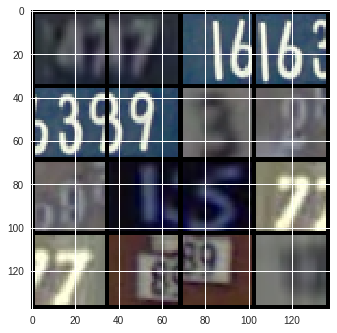

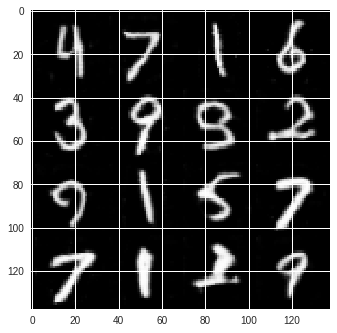

Predicted_MNIST_Labels:  tensor([[4, 7, 1, 6, 3, 9, 3, 2, 9, 1, 5, 7, 7, 1, 3, 7, 3, 0, 8, 2, 4, 2, 3, 1,
         0, 7, 8, 2, 9, 5, 2, 7, 1, 1, 9, 2, 5, 7, 2, 1, 2, 7, 9, 3, 9, 7, 2, 1,
         7, 3, 4, 7, 0, 7, 9, 9, 2, 3, 7, 4, 1, 3, 2, 3, 6, 9, 8, 9, 7, 3, 4, 0,
         5, 3, 1, 8, 4, 8, 1, 6, 4, 1, 6, 9, 9, 7, 9, 5, 3, 2, 5, 5, 1, 5, 3, 0,
         3, 1, 7, 2, 8, 4, 6, 2, 2, 8, 5, 2, 3, 4, 6, 3, 2, 7, 9, 8, 6, 6, 3, 1,
         2, 0, 8, 8, 7, 7, 7, 2]], device='cuda:0')
Actual_SVHN_Labels:  tensor([4, 7, 1, 6, 3, 9, 3, 2, 9, 1, 5, 7, 7, 8, 9, 1, 2, 2, 8, 2, 4, 2, 3, 1,
        0, 7, 1, 2, 3, 3, 2, 7, 1, 1, 9, 2, 5, 7, 7, 1, 2, 7, 1, 1, 9, 7, 1, 1,
        0, 3, 4, 1, 0, 7, 9, 1, 2, 2, 7, 4, 1, 3, 2, 3, 6, 9, 8, 4, 7, 8, 4, 6,
        5, 7, 1, 8, 4, 8, 1, 6, 4, 1, 4, 9, 4, 7, 1, 5, 3, 2, 5, 5, 1, 5, 3, 0,
        5, 1, 7, 2, 3, 5, 3, 2, 2, 1, 5, 2, 2, 4, 6, 7, 1, 1, 2, 8, 6, 6, 3, 1,
        2, 1, 8, 8, 1, 2, 1, 2], device='cuda:0')


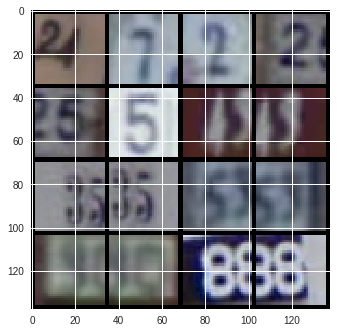

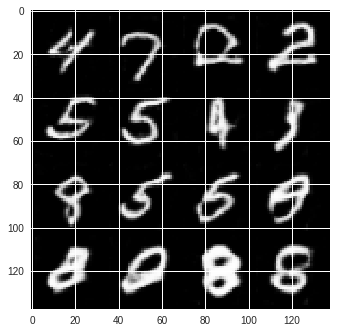

Predicted_MNIST_Labels:  tensor([[4, 7, 2, 2, 5, 5, 4, 3, 8, 5, 5, 9, 3, 2, 8, 5, 7, 1, 1, 7, 5, 4, 2, 0,
         8, 4, 0, 3, 8, 8, 2, 1, 2, 3, 1, 0, 0, 5, 4, 2, 1, 2, 3, 6, 5, 6, 1, 4,
         1, 5, 3, 8, 9, 5, 1, 0, 2, 5, 7, 1, 9, 1, 6, 3, 1, 2, 1, 4, 0, 1, 0, 2,
         1, 5, 2, 7, 2, 0, 6, 7, 0, 6, 0, 4, 9, 3, 7, 5, 3, 0, 8, 2, 5, 6, 7, 5,
         1, 7, 3, 7, 4, 3, 3, 9, 9, 7, 7, 6, 4, 5, 3, 7, 0, 4, 1, 0, 8, 8, 6, 3,
         4, 4, 5, 3, 9, 7, 7, 3]], device='cuda:0')
Actual_SVHN_Labels:  tensor([4, 7, 2, 2, 5, 5, 4, 3, 3, 5, 5, 3, 3, 0, 8, 8, 7, 1, 1, 7, 5, 4, 2, 0,
        8, 4, 0, 3, 8, 8, 2, 1, 2, 2, 1, 0, 0, 5, 4, 2, 1, 2, 3, 6, 5, 6, 1, 4,
        1, 5, 3, 8, 9, 8, 1, 0, 2, 5, 1, 1, 9, 1, 6, 1, 1, 2, 1, 4, 0, 1, 0, 2,
        1, 5, 2, 7, 1, 0, 6, 7, 0, 6, 2, 4, 4, 0, 7, 5, 5, 0, 8, 2, 3, 6, 0, 5,
        1, 1, 3, 7, 4, 3, 3, 1, 4, 1, 1, 6, 4, 5, 3, 1, 0, 4, 1, 0, 0, 8, 6, 3,
        4, 1, 5, 3, 9, 2, 7, 3], device='cuda:0')


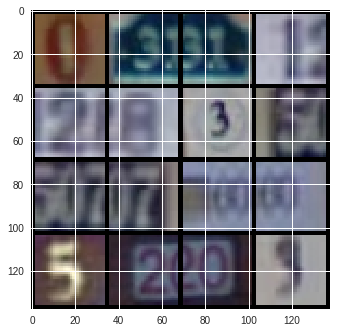

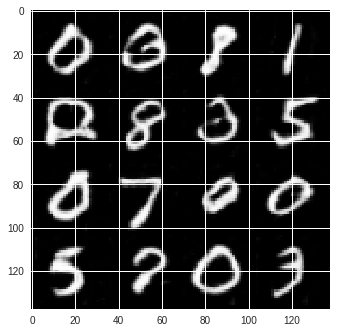

Predicted_MNIST_Labels:  tensor([[0, 3, 8, 1, 2, 8, 3, 5, 0, 7, 9, 0, 5, 2, 0, 3, 6, 4, 1, 4, 9, 5, 3, 3,
         8, 9, 7, 5, 9, 8, 7, 2, 1, 2, 2, 4, 2, 2, 8, 4, 9, 4, 1, 5, 8, 2, 3, 5,
         3, 1, 3, 3, 5, 8, 5, 9, 8, 1, 3, 3, 9, 6, 8, 7, 2, 9, 7, 5, 3, 9, 0, 9,
         0, 1, 5, 2, 6, 9, 7, 0, 4, 1, 9, 2, 1, 1, 1, 7, 6, 1, 0, 0, 1, 7, 5, 1,
         3, 2, 6, 9, 1, 2, 2, 3, 7, 9, 2, 1, 3, 7, 5, 5, 8, 0, 4, 1, 7, 1, 1, 4,
         4, 9, 5, 7, 3, 5, 2, 3]], device='cuda:0')
Actual_SVHN_Labels:  tensor([0, 3, 1, 1, 2, 8, 3, 5, 0, 7, 6, 0, 5, 2, 0, 3, 6, 4, 1, 1, 9, 5, 3, 3,
        2, 2, 7, 5, 9, 8, 1, 2, 1, 2, 2, 4, 2, 2, 8, 1, 7, 4, 1, 5, 8, 2, 3, 5,
        3, 1, 3, 3, 5, 6, 5, 9, 8, 1, 3, 2, 1, 6, 8, 1, 7, 9, 7, 5, 4, 9, 0, 3,
        0, 1, 5, 2, 6, 4, 7, 0, 4, 1, 9, 2, 1, 1, 1, 1, 6, 1, 0, 0, 1, 7, 5, 1,
        3, 2, 6, 3, 1, 2, 2, 1, 7, 9, 2, 1, 3, 1, 6, 5, 8, 0, 1, 1, 7, 1, 1, 4,
        4, 4, 5, 7, 3, 5, 2, 3], device='cuda:0')


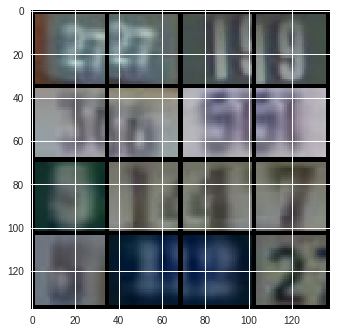

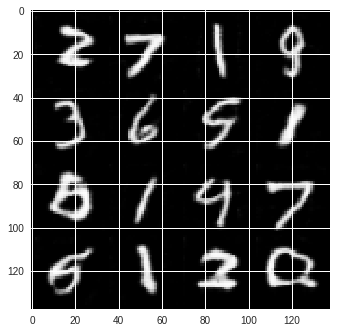

Predicted_MNIST_Labels:  tensor([[2, 7, 1, 9, 3, 6, 5, 8, 5, 1, 9, 7, 5, 1, 2, 2, 7, 0, 3, 9, 4, 8, 7, 5,
         2, 5, 9, 7, 7, 1, 9, 3, 0, 1, 0, 7, 4, 3, 2, 2, 2, 2, 9, 7, 4, 0, 7, 2,
         2, 0, 8, 0, 9, 6, 9, 5, 4, 1, 9, 1, 9, 5, 5, 2, 0, 1, 9, 2, 0, 1, 1, 4,
         1, 2, 2, 1, 9, 8, 9, 1, 2, 9, 2, 4, 8, 2, 8, 3, 5, 5, 7, 9, 8, 6, 9, 9,
         7, 4, 1, 3, 5, 2, 6, 1, 0, 8, 7, 2, 7, 1, 6, 6, 8, 7, 3, 6, 0, 1, 1, 1,
         7, 8, 8, 8, 9, 2, 5, 4]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 7, 1, 9, 3, 6, 5, 1, 5, 1, 4, 7, 5, 1, 2, 2, 7, 9, 3, 1, 4, 8, 1, 5,
        2, 5, 9, 1, 1, 1, 9, 3, 0, 1, 0, 7, 4, 2, 2, 2, 2, 2, 9, 7, 4, 0, 7, 2,
        2, 0, 8, 2, 2, 6, 9, 5, 4, 1, 4, 1, 9, 4, 5, 2, 0, 1, 9, 6, 6, 1, 1, 4,
        1, 7, 2, 1, 4, 1, 3, 1, 2, 9, 2, 4, 3, 2, 1, 3, 6, 5, 1, 9, 8, 6, 1, 3,
        7, 4, 1, 2, 5, 2, 6, 1, 0, 1, 7, 2, 7, 1, 6, 8, 8, 7, 3, 5, 9, 1, 1, 1,
        7, 8, 8, 8, 9, 2, 5, 4], device='cuda:0')


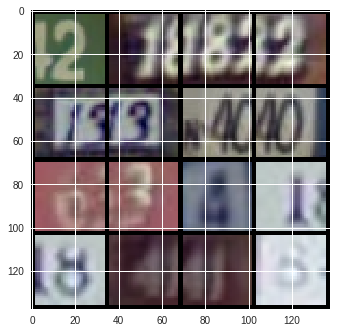

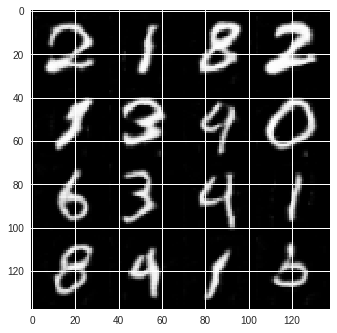

Predicted_MNIST_Labels:  tensor([[2, 1, 8, 2, 3, 3, 4, 0, 6, 3, 4, 1, 5, 4, 1, 3, 4, 2, 5, 6, 6, 2, 0, 1,
         1, 7, 5, 0, 1, 0, 1, 6, 6, 9, 2, 0, 1, 5, 4, 5, 9, 7, 3, 5, 6, 1, 5, 1,
         2, 1, 3, 5, 5, 9, 1, 6, 1, 6, 5, 8, 7, 5, 9, 6, 4, 2, 1, 9, 6, 2, 5, 5,
         2, 4, 6, 5, 9, 2, 5, 1, 2, 0, 4, 2, 6, 1, 7, 1, 9, 3, 5, 8, 8, 2, 2, 7,
         2, 5, 9, 8, 7, 9, 4, 8, 7, 7, 1, 2, 5, 4, 4, 9, 8, 6, 2, 6, 3, 1, 3, 8,
         8, 7, 7, 9, 2, 1, 4, 5]], device='cuda:0')
Actual_SVHN_Labels:  tensor([2, 1, 8, 2, 1, 3, 4, 0, 6, 3, 4, 1, 8, 4, 1, 8, 4, 2, 3, 6, 6, 2, 0, 1,
        1, 7, 5, 6, 1, 0, 1, 6, 6, 9, 2, 0, 1, 5, 4, 5, 4, 7, 2, 5, 6, 1, 3, 1,
        2, 1, 3, 5, 5, 9, 1, 6, 1, 6, 1, 1, 7, 4, 8, 6, 4, 2, 1, 9, 6, 2, 5, 8,
        1, 4, 6, 5, 9, 2, 5, 1, 2, 0, 4, 2, 6, 1, 7, 1, 9, 3, 6, 8, 8, 2, 2, 7,
        2, 5, 2, 8, 7, 1, 4, 8, 1, 7, 1, 2, 5, 4, 4, 9, 8, 6, 2, 6, 9, 1, 2, 9,
        3, 1, 7, 9, 2, 1, 4, 5], device='cuda:0')


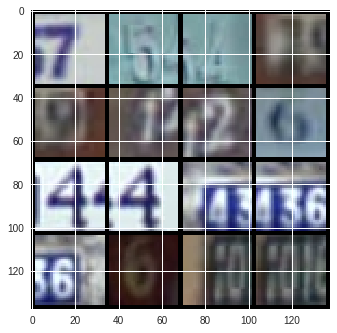

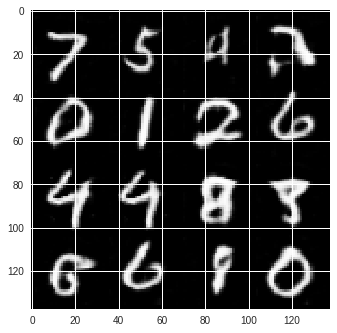

Predicted_MNIST_Labels:  tensor([[7, 5, 4, 2, 0, 1, 2, 6, 4, 4, 8, 3, 8, 6, 8, 0, 5, 6, 2, 3, 1, 3, 8, 3,
         9, 1, 3, 3, 3, 2, 0, 8, 4, 0, 2, 3, 1, 2, 9, 1, 5, 0, 2, 9, 8, 4, 9, 1,
         8, 9, 0, 7, 4, 5, 6, 3, 1, 9, 7, 9, 1, 5, 1, 8, 2, 9, 9, 6, 3, 0, 6, 2,
         5, 0, 6, 7, 1, 5, 6, 8, 4, 6, 7, 8, 4, 9, 2, 7, 7, 2, 6, 8, 4, 0, 2, 5,
         7, 5, 7, 1, 5, 9, 9, 2, 0, 9, 2, 4, 9, 2, 8, 8, 7, 5, 7, 4, 3, 9, 2, 7,
         5, 4, 0, 3, 2, 8, 8, 5]], device='cuda:0')
Actual_SVHN_Labels:  tensor([7, 5, 4, 2, 9, 1, 2, 6, 4, 4, 4, 3, 6, 6, 1, 0, 1, 6, 2, 3, 1, 3, 1, 3,
        9, 1, 3, 2, 7, 2, 0, 3, 1, 0, 2, 3, 1, 2, 9, 1, 3, 0, 1, 9, 8, 1, 1, 1,
        8, 9, 0, 2, 4, 5, 6, 3, 1, 9, 1, 9, 1, 5, 1, 8, 2, 4, 3, 0, 3, 9, 6, 2,
        5, 1, 6, 7, 1, 5, 6, 3, 4, 6, 7, 1, 1, 3, 2, 7, 7, 2, 9, 8, 4, 0, 2, 5,
        7, 5, 7, 1, 5, 3, 1, 2, 6, 9, 2, 1, 9, 2, 8, 1, 7, 5, 3, 4, 3, 4, 2, 7,
        5, 4, 2, 3, 2, 8, 2, 6], device='cuda:0')
Not equal
Test Results on MNIST classifier:
 lo

In [0]:
dig.model_test()

In [0]:
class Flatten(nn.Module):
	def __init__(self):
		super(Flatten, self).__init__()
        
	def forward(self, x):
		N, C, H, W = x.size() # read in N, C, H, W
		return x.view(N, -1)  # 
    
class F(nn.Module):
	'''
	MNIST digit classifier.
	'''
	def __init__(self, input_channel, use_gpu=False):
		super(F, self).__init__()
		self.use_gpu = use_gpu
		self.classify = nn.Sequential(
                nn.Conv2d(input_channel, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True),
                #nn.LeakyReLU(0.2, inplace=True),
                
                nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True),
#                 nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                nn.ReLU(inplace=True),
#                 nn.LeakyReLU(0.2, inplace=True),
            
                nn.Conv2d(256, 128, kernel_size=4, stride=1, padding=0),
                nn.ReLU(inplace=True),
#                 nn.LeakyReLU(0.2, inplace=True),

                Flatten(),
                nn.Linear(128, 10)
#                 nn.Conv2d(128, 10, kernel_size=1, stride=1, padding=0)
              )
		if self.use_gpu:        
			self.type(torch.cuda.FloatTensor)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters())
model = F()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(s_train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [0]:
qwe = torch.load('final_f.tar')

In [0]:
from collections import OrderedDict
gener = {'state_dict':OrderedDict()}
gener['state_dict']=dig.model['g'].state_dict
disc = {'state_dict':OrderedDict()}
disc['state_dict']=dig.model['d'].state_dict
torch.save(gener['state_dict'],'generator_al0.tar')
torch.save(disc['state_dict'],'discriminator_al0.tar')

In [0]:
gener

{'state_dict': <bound method Module.state_dict of generator(
   (network): Sequential(
     (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace)
     (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace)
     (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace)
     (9): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (10): Tanh()
   )
 )>}

In [0]:
for i in qwe:
    if(i == 'state_dict'):
    print(qwe[i]['classify.0.weight'].size())

torch.Size([64, 3, 3, 3])


In [0]:
torch.__version__

'1.0.1.post2'